## Load parquet

In [1]:
%matplotlib widget
%matplotlib inline

In [2]:

import pandas as pd

import matplotlib.pyplot as plt
import pandas_ta as ta

In [3]:
df = pd.read_parquet("data.parquet")

In [4]:
df.head()

,instrument_id,ts,open_price,close_price,high_price,low_price,volume
0,1,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0
1,1,2018-01-23 21:35:00+00:00,114.02,114.02,114.02,114.02,10.0
2,1,2018-01-23 20:55:00+00:00,114.20,114.23,114.26,114.16,76837.0
3,1,2018-01-23 20:50:00+00:00,114.37,114.21,114.39,114.19,34299.0
4,1,2018-01-23 20:45:00+00:00,114.33,114.36,114.41,114.31,27240.0


In [5]:
df.groupby("instrument_id").count()

,ts,open_price,close_price,high_price,low_price,volume
instrument_id,,,,,,
1,85215,85215,85215,85215,85215,85215
2,72120,72120,72120,72120,72120,72120
3,98530,98530,98530,98530,98530,98530
4,119009,119009,119009,119009,119009,119009
5,100777,100777,100777,100777,100777,100777
...,...,...,...,...,...,...
528,1588,1588,1588,1588,1588,1588
530,62633,62633,62633,62633,62633,62633
531,70902,70902,70902,70902,70902,70902


## Analyze single stock

### Create dataset with sliding averages

In [6]:
sliding_window_df = df[df["instrument_id"] == 1]

## Exclude 1-st hour and last hour

In [7]:
sliding_window_df.head()

,instrument_id,ts,open_price,close_price,high_price,low_price,volume
0,1,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0
1,1,2018-01-23 21:35:00+00:00,114.02,114.02,114.02,114.02,10.0
2,1,2018-01-23 20:55:00+00:00,114.20,114.23,114.26,114.16,76837.0
3,1,2018-01-23 20:50:00+00:00,114.37,114.21,114.39,114.19,34299.0
4,1,2018-01-23 20:45:00+00:00,114.33,114.36,114.41,114.31,27240.0


In [8]:
def preprocess_data(df):
    # Sort values with ts
    df = df.sort_values("ts")
    # Reset index
    df = df.reset_index(drop=True)

    # Add MACD
    df.ta.macd(append=True)

    # Add RSI
    df.ta.rsi(append=True)

    # Rename columns
    df = df.rename(columns={
        "MACD_12_26_9": "MACD",
        "MACDs_12_26_9": "MACDs",
        "MACDh_12_26_9": "MACDh",
        "RSI_14": "RSI"})

    # Calc RSI signals
    RSI_oversold_threshold = 30
    RSI_overbouht_threshold = 70

    df["RSI_oversold"] = df["RSI"] <= RSI_oversold_threshold
    df["RSI_overbought"] = df["RSI"] >= RSI_overbouht_threshold

    df["MACD_crossover"] = (df["MACDh"] > 0) & (df["MACDh"].shift() <= 0)
    df["MACD_crossunder"] = (df["MACDh"] <= 0) & (df["MACDh"].shift() > 0)

    return df

In [9]:
sliding_window_df = preprocess_data(sliding_window_df)
sliding_window_df.head()

,instrument_id,ts,open_price,close_price,high_price,low_price,volume,MACD,MACDh,MACDs,RSI,RSI_oversold,RSI_overbought,MACD_crossover,MACD_crossunder
0,1,2018-01-23 11:05:00+00:00,114.50,114.50,114.50,114.50,1.0,NaN,NaN,NaN,NaN,False,False,False,False
1,1,2018-01-23 11:10:00+00:00,114.27,114.27,114.27,114.27,2.0,NaN,NaN,NaN,0.0,True,False,False,False
2,1,2018-01-23 13:40:00+00:00,114.00,114.00,114.00,114.00,18.0,NaN,NaN,NaN,0.0,True,False,False,False
3,1,2018-01-23 13:45:00+00:00,114.00,114.00,114.00,114.00,882.0,NaN,NaN,NaN,0.0,True,False,False,False
4,1,2018-01-23 13:50:00+00:00,113.82,113.82,113.82,113.82,100.0,NaN,NaN,NaN,0.0,True,False,False,False


Show MACD RSI

In [10]:
def color_zone(ax, points, alpha, color):
    start_point = 0
    end_point = 0
    for x in points:
        if start_point == 0:
            start_point = x
            end_point = x + 1
        else:
            if end_point == x:
                # Continue
                end_point += 1
            else:
                # Draw and reset
                ax.axvspan(start_point, end_point, alpha=alpha, color=color)
                start_point = 0
                end_point = 0
    
    if start_point != 0:
        # Draw and reset
        ax.axvspan(start_point, end_point, alpha=alpha, color=color)
        start_point = 0
        end_point = 0

In [11]:
def plot_candles(df):
    width=1
    width2=0.2

    pricesup = df[df["close_price"] >= df["open_price"]]
    pricesdown = df[df["close_price"] < df["open_price"]]

    plt.bar(pricesup.index, pricesup["close_price"] - pricesup["open_price"], width, bottom=pricesup["open_price"], color='g')
    plt.bar(pricesup.index, pricesup["high_price"] - pricesup["close_price"], width2, bottom=pricesup["close_price"], color='g')
    plt.bar(pricesup.index, pricesup["low_price"] - pricesup["open_price"], width2, bottom=pricesup["open_price"], color='g')

    plt.bar(pricesdown.index, pricesdown["close_price"] - pricesdown["open_price"], width, bottom=pricesdown["open_price"], color='r')
    plt.bar(pricesdown.index, pricesdown["high_price"] - pricesdown["close_price"], width2, bottom=pricesdown["close_price"], color='r')
    plt.bar(pricesdown.index, pricesdown["low_price"] - pricesdown["open_price"], width2, bottom=pricesdown["open_price"], color='r')
    plt.grid()

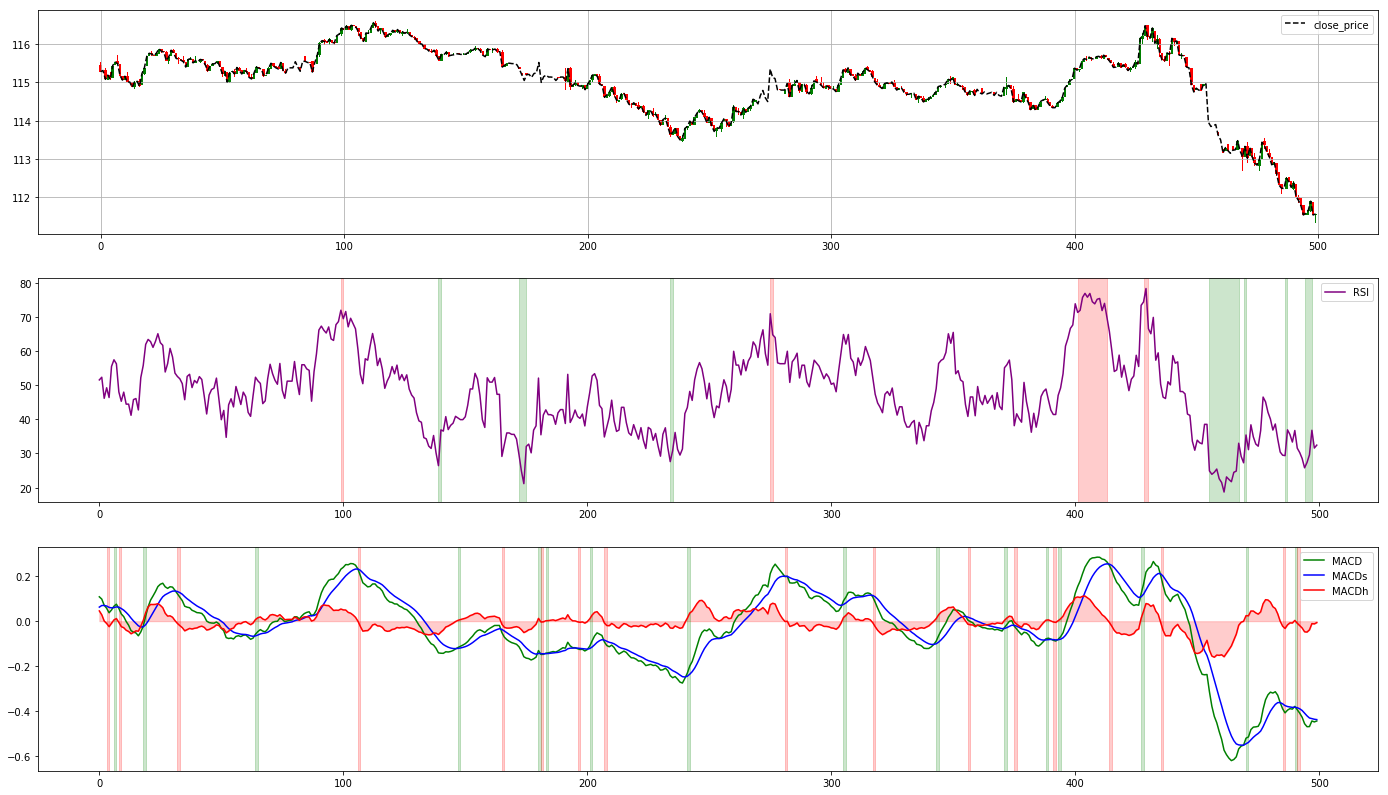

In [12]:
plot_df = sliding_window_df.iloc[1000:1500].reset_index()

plt.figure(figsize=(24,14))
plt.subplot(3, 1, 1)
plot_df["close_price"].plot(color="black", linestyle='--')
plot_candles(plot_df)
plt.legend()

plt.subplot(3, 1, 2)
ax1 = plot_df["RSI"].plot(color="purple")
# Show oversold zone
color_zone(ax1, plot_df[plot_df["RSI_oversold"]].index, 0.2, "green")
# Show overbought zone
color_zone(ax1, plot_df[plot_df["RSI_overbought"]].index, 0.2, "red")
plt.legend()

plt.subplot(3, 1, 3)
ax3 = plot_df["MACD"].plot(color="green")
plot_df["MACDs"].plot(ax=ax3,color="blue")
plot_df["MACDh"].plot(ax=ax3,color="red")
ax3.fill_between(plot_df.index, plot_df["MACDh"], alpha=0.2, color="red")
# Show crossover moments
for x in plot_df[plot_df["MACD_crossover"]].index:
    ax3.axvspan(x, x+1, alpha=0.2, color="green")      
# Show crossunder moments
for x in plot_df[plot_df["MACD_crossunder"]].index:
    ax3.axvspan(x, x+1, alpha=0.2, color="red")
plt.legend()

# Create manual bot

In [14]:
# Create dataset for bot
# Preprocess data
bot_df = preprocess_data(df[df["instrument_id"] == 1])
# Select columns
bot_df = bot_df[["ts","open_price","close_price","high_price","low_price","volume","MACD","RSI"]]
bot_df.head()

,ts,open_price,close_price,high_price,low_price,volume,MACD,RSI
0,2018-01-23 11:05:00+00:00,114.50,114.50,114.50,114.50,1.0,NaN,NaN
1,2018-01-23 11:10:00+00:00,114.27,114.27,114.27,114.27,2.0,NaN,0.0
2,2018-01-23 13:40:00+00:00,114.00,114.00,114.00,114.00,18.0,NaN,0.0
3,2018-01-23 13:45:00+00:00,114.00,114.00,114.00,114.00,882.0,NaN,0.0
4,2018-01-23 13:50:00+00:00,113.82,113.82,113.82,113.82,100.0,NaN,0.0


In [15]:
from bot import TradingBot

# Test bot
bot = TradingBot(stop_loss=0.02)

bot.reset()

for index, data in bot_df.iterrows():
    bot.process(data)

bot.profit * 100

51.30353431414033

# Test bot on different stocks

In [16]:
def test_bot_profit(df):
    # Preprocess data
    bot_df = preprocess_data(df)
    # Select columns
    bot_df = bot_df[["ts","open_price","close_price","high_price","low_price","volume","MACD","RSI"]]

    # Create bot instance
    bot = TradingBot(stop_loss=0.02)
    # Reset bot
    bot.reset()
    # Run bot
    for index, data in bot_df.iterrows():
        bot.process(data)

    return bot.profit * 100

In [18]:
from joblib import Parallel, delayed, parallel_backend

jobs = []

def thread_func(stock_id, stock_df):
    # Check size of dataset
    if stock_df.shape[0] > 8 * 60:
        profit = test_bot_profit(stock_df)

        return {"id":stock_id,"profit":profit}
    
    return {}

with parallel_backend("multiprocessing", n_jobs=8):
    bot_profit_list = Parallel()(delayed(thread_func)(stock_id, stock_df) for stock_id, stock_df in df.groupby("instrument_id"))

bot_profit_df = pd.DataFrame(bot_profit_list).dropna()
bot_profit_df

,id,profit
0,1.0,50.903077
1,2.0,50.165367
2,3.0,80.754314
3,4.0,167.040125
4,5.0,113.396528
...,...,...
523,528.0,-5.194677
524,530.0,96.442342
525,531.0,217.014007
526,532.0,6.773616


In [19]:
bot_profit_df.sort_values("profit")

,id,profit
362,363.0,-289.663648
198,199.0,-256.947931
279,280.0,-250.773432
267,268.0,-237.478502
20,21.0,-151.909904
...,...,...
216,217.0,353.526732
102,103.0,361.396604
317,318.0,364.080361
156,157.0,387.398335


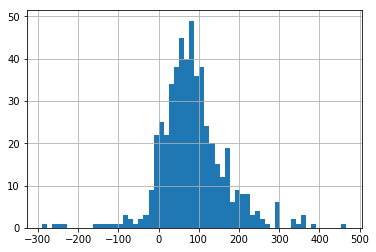

In [28]:
bot_profit_df["profit"].hist(bins=60)